In [1]:
push!(LOAD_PATH, pwd()*"/..")
using SIS,IM,PayloadGraph,PyPlot, Epidemics,JLD, TwoLevelGraphs,Dierckx,Plotting,DataAnalysis,GraphGeneration
import LightGraphs


In [2]:
function plot_comparison(path_regular,path_two_level,apply_finite_size=true)
    yvals_regular_g = 0
    pvals_regular_g = 0
    yvals_two_level_g = 0
    pvals_two_level_g = 0
    yvals_tl,pvals_tl = 0,0
    N,n_n,c_r,alpha,beta,k,xx,yy,s_eff_two_level,splus_two_level = 0,0,0,0,0,0,0,0,0,0
    l,r = 0,0
    imk,imsf = 0,0
    has_two_level= false
    yvals_plot,pvals_plot = [],[]
    for (idx,path) in enumerate([path_regular,path_two_level])
        d = load(path)

        params = d["params"]
        compact = params["compact"]
        runs = d["runs"]
        if compact
            sizes = runs.sizes
            pvals = runs.p_reach
            yvals = runs.y_reach
        else
            num_fixed = get_num_fixed(runs) #d["num_fixed"]
            sizes = get_sizes(runs) #d["sizes"]
            yvals,pvals = get_p_reach(runs,N)
        end
        N = params["N"]
        alpha = params["alpha"]
        beta = params["beta"]
        k = params["k"]
        c_r = get_c_r(N,alpha,beta)
        n_n = get_n_n(N,alpha,beta)
        graph_information = params["graph_information"]
        graph_type = params["graph_type"]
        
        push!(yvals_plot,yvals)
        push!(pvals_plot,pvals)

        if graph_type == TWO_LEVEL
            has_two_level = true
            t = graph_information.data.t
            xx,yy,s_eff_two_level,splus_two_level = plot_two_level_schematic(t,alpha,beta,N,apply_finite_size)
            #k = t.l + t.r
            l = t.l
            r = t.r
            m = t.m
            yvals_two_level_g = yvals
            pvals_two_level_g = pvals
#             imk = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
        elseif graph_type == SCALE_FREE
            print("Scale Free")
            #k = t.l + t.r
            yvals_two_level_g = yvals
            pvals_two_level_g = pvals
            imsf = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_scale_free(x,alpha,beta,k,N) , x -> 1 + beta);
        elseif graph_type == GAMMA
            print("GAMMA")
            #k = t.l + t.r
            sigma_k = graph_information.data
            yvals_two_level_g = yvals
            pvals_two_level_g = pvals
            imsf = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_gamma(x,alpha,beta,k,sigma_k,N) , x -> 1 + beta);
        elseif graph_type == REGULAR
            print("Regular")
            yvals_regular_g = yvals
            pvals_regular_g = pvals
        end
                
        
    end

    im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
    imk = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
#     imk = InfectionModel(x -> get_n_plus(x,alpha,beta,k,N) , x -> get_n_minus(x,alpha,beta,k,N));
    
    
    
    println("k = $k")
    pygui(false)
    figure(2)
    if has_two_level
        loglog(xx,yy,"-k")
    end
    loglog(yvals_plot[1],pvals_plot[1],"ob")
    loglog(yvals_plot[2],pvals_plot[2],"ok")

    plot_schematics(N,n_n,c_r,alpha,beta,imk,imsf,k)
    figure(2)
    ylim([1e-6,1])
    xlim([1/N,1.1])
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N, k = $k, l = $l, r = $r\$"))
    figure(3)
    if has_two_level
        plot(xx,s_eff_two_level(xx),"-k")
    end
    return s_eff_two_level,splus_two_level
end
   

function load_p_reach_data(path)
    d = load(path)

    params = d["params"]
    compact = params["compact"]
    runs = d["runs"]
    if compact
        sizes = runs.sizes
        pvals = runs.p_reach
        yvals = runs.y_reach
    else
        num_fixed = get_num_fixed(runs) #d["num_fixed"]
        sizes = get_sizes(runs) #d["sizes"]
        yvals,pvals = get_p_reach(runs,N)
    end
    
    epidemic_params = QuadraticEpidemicParams(params["N"],params["alpha"],params["beta"])
    
    k = params["k"]
    graph_information = params["graph_information"]
    graph_type = params["graph_type"]
    return params,yvals,pvals,epidemic_params,k,graph_information,graph_type,runs
end
    
function summarize_p_reach_data(path)
    params,yvals,pvals,epidemic_params,k,graph_information,graph_type,runs = load_p_reach_data(path)
    N = epidemic_params.N
    alpha = epidemic_params.alpha
    beta = epidemic_params.beta
    n_n = epidemic_params.n_n
    c_r = epidemic_params.c_r
 
    println("N = $N, k = $k, y_n = $(n_n/N), c_r = $(c_r)")
    println("alpha = $(alpha), beta = $(beta)")
    println("Graph Type: $(graph_type)")
    if graph_type == Int(two_level_rg)
        t = graph_information.data.t
        println("k_i = $(t.l), k_e = $(t.r)")
    end
    println("num trials: $(length(runs.sizes))")
        
end

function plot_comparisons(paths,apply_finite_size=true)
    N,n_n,c_r,alpha,beta,k,xx,yy,s_eff_two_level,splus_two_level = 0,0,0,0,0,0,0,0,0,0
    l,r = 0,0
    has_two_level= false
    yvals_simulation,pvals_simulation = [],[]
    yvals_theory,pvals_theory = [],[]
    yvals_tl_theory,pvals_tl_theory = [],[]
    ims = []
    simulation_labels = []
    theory_labels = []
    for (idx,path) in enumerate(paths)
        params,yvals,pvals,epidemic_params,k,graph_information,graph_type,runs = load_p_reach_data(path)
        N = epidemic_params.N
        alpha = epidemic_params.alpha
        beta = epidemic_params.beta
        n_n = epidemic_params.n_n
        c_r = epidemic_params.c_r
    
        push!(yvals_simulation,yvals)
        push!(pvals_simulation,pvals)
        yy = collect(1/N:2*n_n/N/100:2*n_n/N)
        pp = 0
        label = "default"
        println(graph_type)

        if graph_type == Int(two_level_rg)
            has_two_level = true
            t = graph_information.data.t
            yy,pp,s_eff_two_level,splus_two_level = plot_two_level_schematic(t,alpha,beta,N,apply_finite_size)
            label = "TL \$k_i = $(t.l), k_e = $(t.r)\$"
#             imk = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);
        elseif graph_type == Int(scale_free_rg )
            im = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_scale_free(x,alpha,beta,k,N) , x -> 1 + beta)
            pp = P_reach_fast(im,N,1.0/N,yy,true)
            label = "SF \$k = $k\$"
        elseif graph_type == Int(gamma_rg)
            #k = t.l + t.r
            sigma_k = graph_information.data
            im = InfectionModel(x -> 1 + beta + get_s_eff_degree_distribution_gamma(x,alpha,beta,k,sigma_k,N) , x -> 1 + beta)
            pp = P_reach_fast(im,N,1.0/N,yy,true)
            label = "\$GAMMA k = $k \sigma_{k} = $(sigma_k) \$"
        elseif graph_type == Int(regular_rg )
            im = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta)
            pp = P_reach_fast(im,N,1.0/N,yy,true)
            label = "REG \$k = $k \$"
        end
        println(label)
        push!(yvals_theory,yy)
        push!(pvals_theory,pp)
        push!(theory_labels,latexstring("Th. "*label))
        push!(simulation_labels,latexstring("Sim. "*label))
       
    end
    
    colors = ["b","g","r","k","c"]
    colors = repmat(colors,3)
   
    figure()
    for i = 1:length(yvals_theory)
        loglog(yvals_theory[i],pvals_theory[i],color=colors[i],label=theory_labels[i])
    end
    for i = 1:length(yvals_simulation)
        loglog(yvals_simulation[i],pvals_simulation[i],"o",fillstyle="none",color=colors[i],label=simulation_labels[i])
    end
    
#     pygui(false)
    legend(loc="best")
    ylim([1e-6,1])
    xlim([1/N,1.1])
    xlabel(L"y")
    ylabel(L"P_{reach}(y)")
    title(latexstring("\$y_n = $(n_n/N), c_r = $c_r, N = $N, k = $k\$"))
end
    
           

plot_comparisons (generic function with 2 methods)

In [3]:
data_dir_path = "../../data/"  #"/mnt/D/windows/MIT/classes/6/338/project/data/"
filenames = split(readstring(`ls $data_dir_path`));
filenames

156-element Array{SubString{String},1}:
 "epidemics_graph_compact_2016-10-16T17:42:28.jld"
 "epidemics_graph_compact_2016-10-16T17:43:08.jld"
 "epidemics_graph_compact_2016-10-17T02:06:26.jld"
 "epidemics_graph_compact_2016-10-17T02:08:12.jld"
 "epidemics_graph_compact_2016-10-17T03:48:38.jld"
 "epidemics_graph_compact_2016-10-17T03:59:14.jld"
 "epidemics_graph_compact_2016-10-17T21:49:36.jld"
 "epidemics_graph_compact_2016-10-17T21:51:04.jld"
 "epidemics_graph_compact_2016-10-17T22:17:02.jld"
 "epidemics_graph_compact_2016-10-17T22:18:41.jld"
 "epidemics_graph_compact_2016-10-17T22:35:52.jld"
 "epidemics_graph_compact_2016-10-17T22:38:11.jld"
 "epidemics_graph_compact_2016-10-17T23:10:45.jld"
 ⋮                                                
 "epidemics_graph_compact_2017-01-11T02:37:41.jld"
 "epidemics_graph_compact_2017-01-11T03:12:40.jld"
 "epidemics_graph_compact_2017-01-11T03:13:50.jld"
 "epidemics_graph_compact_2017-01-11T03:48:40.jld"
 "epidemics_graph_compact_2017-01-11T03:50

In [52]:
summarize_p_reach_data(data_dir_path*filenames[end-4])

N = 400, k = 20, y_n = 0.2, c_r = 0.2
alpha = 1.25, beta = 0.25
Graph Type: 3
k_i = 1, k_e = 19
num trials: 39997


3
computed interpolations
TL $k_i = 1, k_e = 19$
2
REG $k = 20 $


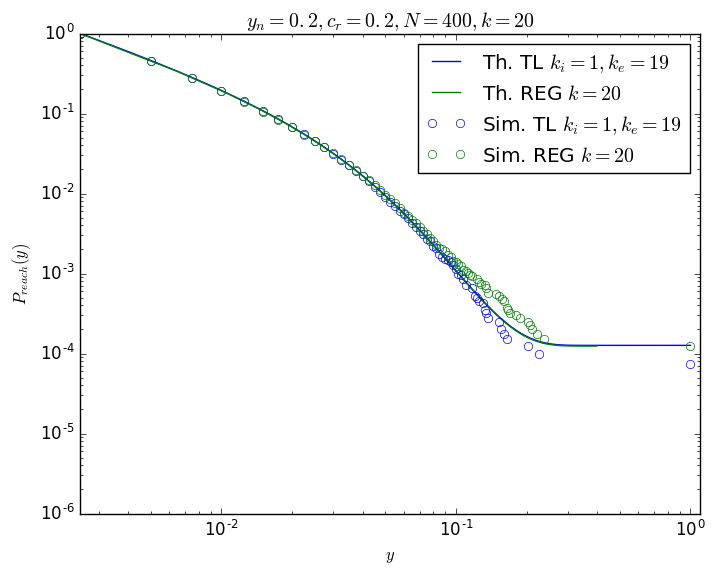

In [53]:
path_regular = data_dir_path*filenames[end-3]
path_two_level = data_dir_path*filenames[end-1]
subpaths = filenames[end-4:end-3]
# push!(subpaths,filenames[end-27])
paths = [data_dir_path*_ for _ in subpaths]
close("all")
# s_t_l,splus_t_l = plot_comparison(path_regular,path_two_level,true)
plot_comparisons(paths,true)
gcf()
# imtl = InfectionModel(x -> 1 + beta + s_t_l(x) , x -> 1 + beta);
# runs_well_mixed_tl = run_epidemics(10000, () -> run_epidemic_well_mixed(N,imtl,1.0));
# yvals_well_mixed_tl,pvals_well_mixed_tl = get_p_reach(runs_well_mixed_tl,N)
# figure(2)
# plot(yvals_well_mixed,pvals_well_mixed,"^b")
# plot(yvals_well_mixed_full,pvals_well_mixed_full,"^r")
# plot(yvals_well_mixed_tl,pvals_well_mixed_tl,"^k")

In [ ]:
close("all")

In [8]:
plot_comparisons(["a","ab"],true)

LoadError: error compiling plot_comparisons: unsupported or misplaced expression "block" in function plot_comparisons

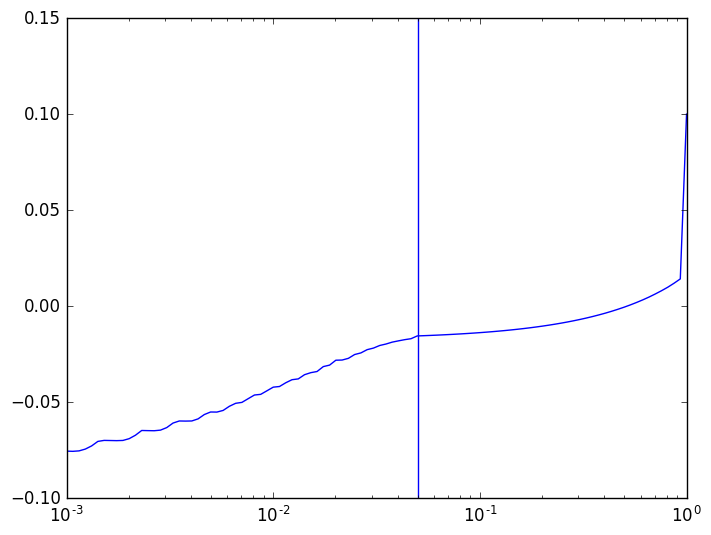

PyObject <matplotlib.lines.Line2D object at 0x32a230a90>

In [25]:
xx = logspace(-3,0,100) 
semilogx(xx,s_t_l(xx))
# semilogx(xx,splus_t_l(xx))
axvline(0.05)

In [18]:
###Compact###
d = load(data_dir_path*filenames[end-7])

GAMMA = 5
SCALE_FREE = 4
TWO_LEVEL = 3
REGULAR = 2
RANDOM = 1

params = d["params"]
compact = params["compact"]
runs = d["runs"]
if compact
    sizes = runs.sizes
    pvals = runs.p_reach
    yvals = runs.y_reach
else
    num_fixed = get_num_fixed(runs) #d["num_fixed"]
    sizes = get_sizes(runs) #d["sizes"]
    xvals,pvals = get_p_reach(runs,N)
end

    
N = params["N"]
alpha = params["alpha"]
beta = params["beta"]
k = params["k"]
num_trials = length(runs.sizes)
graph_model = params["graph_model"]
graph_type = params["graph_type"]
graph_information = params["graph_information"]

println("Graph Type: $(graph_type)")

c_r = get_c_r(N,alpha,beta)
n_n = get_n_n(N,alpha,beta)

if graph_type == TWO_LEVEL
    t = graph_information.data.t
    k = t.l + t.r
    m = t.m
    println(t)
end

if graph_type == GAMMA
    sigma_k = graph_information.data
    println("sigma_k: $(sigma_k)")
end
println("k = $k, N = $N")
# println("$(length(runs)) runs")

im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
imk = InfectionModel(x -> 1 + beta + get_s_eff_exact(x,alpha,beta,k,N) , x -> 1 + beta);

y_n, y_minus, y_plus, y_p,critical_determinant = get_parameters(N,alpha,beta)

Graph Type: 5
sigma_k: 0.2
k = 12, N = 2000


(0.2,0.010557280900008416,0.18944271909999158,0.20954451150103323,0.19999999999999996)

In [35]:
k,n_n,c_r,N,t.l,t.r,t.m,num_trials

LoadError: LoadError: UndefVarError: t not defined
while loading In[35], in expression starting on line 1

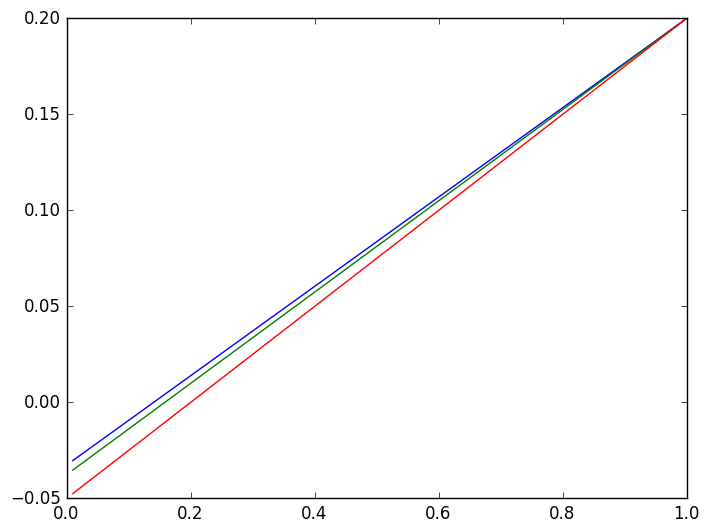

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31de83a50>

In [34]:
xx = 0.0:0.01:1.0
ss = get_s_eff_degree_distribution(xx,alpha,beta,k,N)
ss1 = get_s_eff_exact(xx,alpha,beta,k,N)
ss2 = get_s_eff_exact(xx,alpha,beta,N-1,N)
plot(xx,ss,"b")
plot(xx,ss1,"g")
plot(xx,ss2,"r")



In [6]:
p_k = get_p_k_barabasi_albert(k)

p_k (generic function with 1 method)

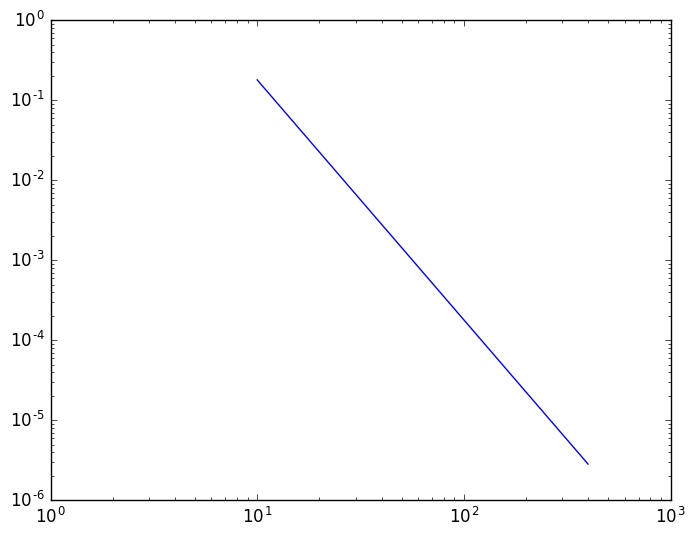

0.9994329648768864


In [7]:
kk = 1:N-1
p_k_arr = [p_k(_) for _ in kk]

loglog(kk,p_k_arr)
println(sum(p_k_arr))

In [22]:
pvals,yvals

([1.0,0.97458,0.97311,0.97303,0.97301],[0.0125,0.025,0.0375,0.05,1.0])

In [8]:
num_trials

99122

In [9]:
imk.dt = imk.dt/5

0.0008888888888888889

In [10]:
num_sims = 100000
runs_well_mixed = run_epidemics(num_sims, () -> run_epidemic_well_mixed(N,imk,1.0));
yvals_well_mixed,pvals_well_mixed = get_p_reach(runs_well_mixed,N)
# runs_well_mixed_full = run_epidemics(num_sims, () -> run_epidemic_well_mixed(N,im,1.0));
# yvals_well_mixed_full,pvals_well_mixed_full = get_p_reach(runs_well_mixed_full,N)

([0.0125,0.025,0.0375,0.05,0.0625,0.075,0.0875,0.1,0.1125,0.125  …  0.25,0.2625,0.275,0.2875,0.3,0.3125,0.325,0.3375,0.3625,1.0],[1.0,0.38101,0.19459,0.11278,0.07051,0.04759,0.03337,0.02457,0.01836,0.0145  …  0.00511,0.00494,0.00488,0.00481,0.00473,0.00467,0.00462,0.0046,0.00458,0.00456])

In [8]:
imtl = InfectionModel(x -> 1 + beta + s_t_l(x) , x -> 1 + beta);
runs_well_mixed_tl = run_epidemics(100000, () -> run_epidemic_well_mixed(N,imtl,1.0));
yvals_well_mixed_tl,pvals_well_mixed_tl = get_p_reach(runs_well_mixed_tl,N)

LoadError: LoadError: UndefVarError: s_t_l not defined
while loading In[8], in expression starting on line 1

In [52]:
yvals_well_mixed,pvals_well_mixed

([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025  …  0.185,0.1875,0.1925,0.1975,0.2,0.205,0.2075,0.2375,1.0,1.0025],[1.0,0.458292,0.27656,0.188523,0.136378,0.103417,0.08053,0.064275,0.0517375,0.0422225  …  0.000145,0.00014,0.0001375,0.00013,0.0001275,0.000125,0.0001225,0.00012,0.0001175,5.0e-6])

In [12]:
xvals_two_level_g,pvals_two_level_g = yvals,pvals

([0.000625,0.00125,0.001875,0.0025,0.003125,0.00375,0.004375,0.005,0.005625,0.00625  …  0.129375,0.1325,0.135,0.145,0.15625,0.196875,0.200625,0.220625,0.27625,1.0],[1.0,0.4766,0.305,0.2247,0.1795,0.1492,0.1245,0.1068,0.0927,0.083  …  0.0024,0.0023,0.0022,0.0021,0.002,0.0019,0.0018,0.0017,0.0016,0.0015])

In [9]:
xvals_regular12_g,pvals_regular12_g = yvals,pvals

([0.0025,0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02,0.0225,0.025  …  0.135,0.1375,0.14,0.1575,0.16,0.1625,0.185,0.19,0.1925,0.2275],[1.0,0.4738,0.3106,0.2218,0.1667,0.1338,0.1091,0.0909,0.0786,0.0676  …  0.0013,0.001,0.0009,0.0008,0.0007,0.0006,0.0004,0.0003,0.0002,0.0001])

In [13]:
k = 10
#y_n = 0.1
c_r = 0.2 #0.18
N = 1000#100000#400
n_n = 250#10#80#y_n*N
beta = 4.0/(c_r*n_n)
alpha = (N*beta)/n_n
println("N=$N, alpha = $alpha, beta = $beta")

#Generate a random startin vector
m = 10#20 number of nodes in a community
n = Int(N/m) 
l = 9#Int(m/2)#10#internal
r = 1#2#Int(m/2)#2 #external

im = InfectionModel(x -> 1 + alpha*x , x -> 1 + beta);
imk = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);


y_desired = 0.5

t = TwoLevel(N,m,l,r)
#distribute_randomly(t,n)
adjust_infecteds(t,y_desired)
make_consistent(t)
assert(is_valid(t))
println(t.i/t.N)

N=1000, alpha = 0.32, beta = 0.08
0.5


In [14]:
xx,yy,s_eff_two_level = get_p_reach_theory(t,alpha,beta,N)

([0.001,0.00107227,0.00114976,0.00123285,0.00132194,0.00141747,0.00151991,0.00162975,0.00174753,0.00187382  …  0.53367,0.572237,0.613591,0.657933,0.70548,0.756463,0.811131,0.869749,0.932603,1.0],Any[1.0,0.9318500145242932,0.868403081314215,0.8093288591903148,0.7543272923508049,0.7031261122867793,0.6554728565269202,0.6111203543758607,0.5698355789837416,0.5314005347060262  …  0.033296639620999186,0.03329407754062044,0.033293188694503165,0.03329332978573531,0.033293690445349626,0.03329399853210305,0.0332925118954452,0.03329230678795077,0.03329270087441798,0.03329359909427935],s)

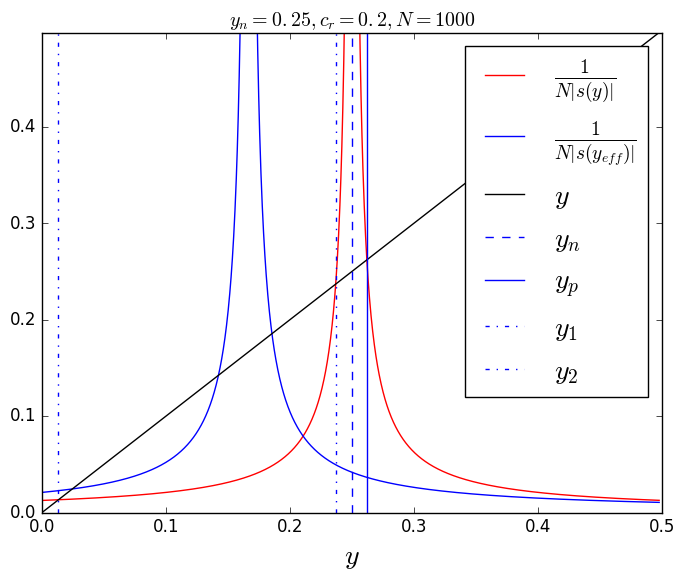

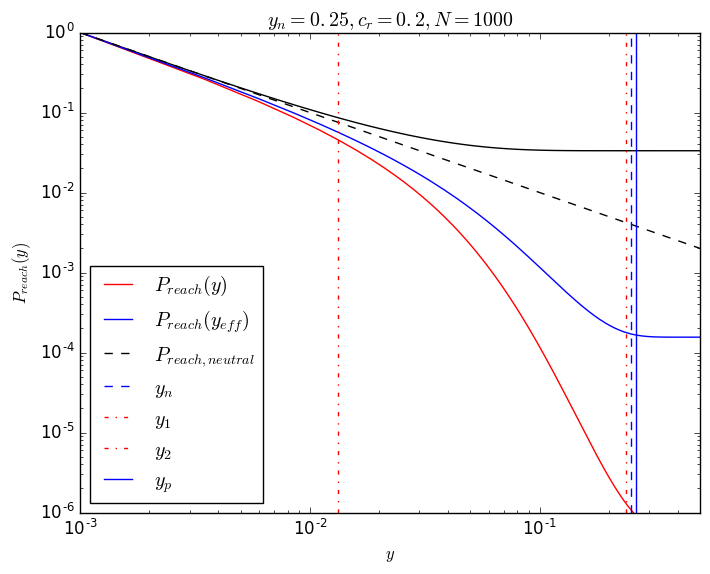

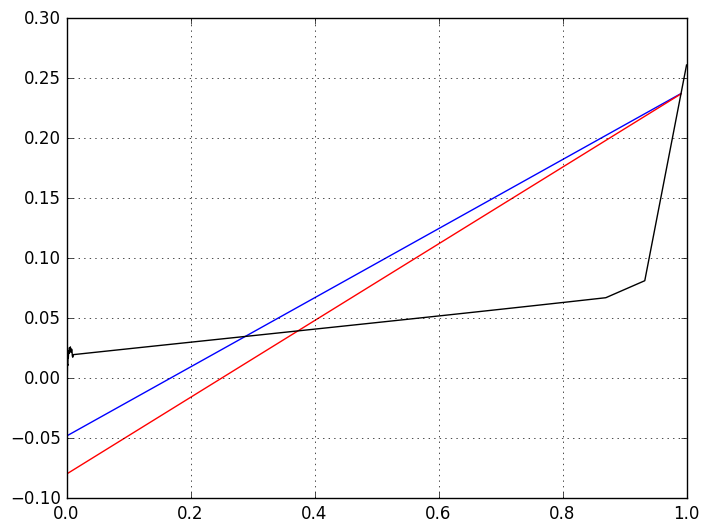

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32762e810>

In [15]:
pygui(false)
figure(2)
loglog(xx,yy,"-k")
# loglog(xvals_regular12_g,pvals_regular12_g,"ob")
# loglog(xvals_two_level_g,pvals_two_level_g,"ok")


# #loglog(xvals_regular4_g,pvals_regular4_g,"og")
# #loglog(xvals_two_level_wm,pvals_two_level_wm,"^k")
# loglog(xvals_two_level_g1,pvals_two_level_g1,"^k")
# loglog(xvals_two_level_g2,pvals_two_level_g2,"sk")

plot_schematics(N,n_n,c_r,alpha,beta,im,imk,k)
#plot_schematics(20,n_n,alpha,beta,im,imk,10)
figure(2)
ylim([1e-6,1])
# xlim([1e-3,1e2])
figure(3)
plot(xx,s_eff_two_level(xx),"-k")

In [66]:
figure(2)
loglog(xx,yy)

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3177d0450>

In [11]:
#t = runs[1].graph_information.data.t
println("Data P_fixed: $(num_fixed/num_trials)")

println("N: $N")
println("n_n: $(n_n)")
println("r: $(t.r), l: $(t.l)")
println("alpha: $alpha, beta: $beta")

LoadError: LoadError: UndefVarError: num_fixed not defined
while loading In[11], in expression starting on line 2

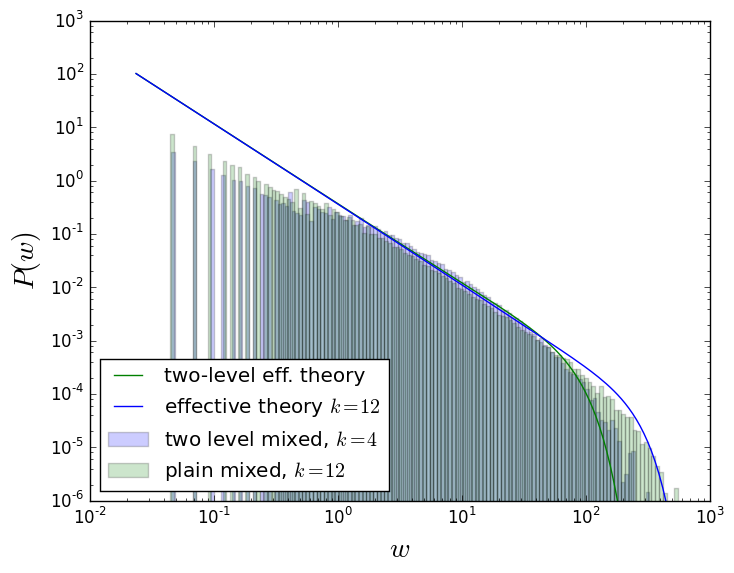

3954


In [22]:
s_eff_fn(x) = get_s_effective_two_level_interp(x,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
#plot_w(sizes,N,alpha,beta,s_eff_fn,"two level graph")
plot_w(sizes_two_level,N,alpha,beta,s_eff_fn, "two level mixed")
plot_w(sizes_well_mixed,N,alpha,beta,t.l + t.r, "plain mixed")

In [86]:
y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)

(Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0),Spline1D(knots=[4.00249e-5,7.97835e-5 … 0.981,0.991] (286 elements), k=1, extrapolation="extrapolate", residual=0.0))

In [104]:
@time P_reach(s,splus,N,1/N,xx)
@time P_reach_fast(s,splus,N,1/N,xx)

  0.411884 seconds (285.47 k allocations: 13.399 MB, 85.95% gc time)
  2.352493 seconds (9.41 M allocations: 446.035 MB, 41.74% gc time)


20-element Array{Any,1}:
 11.2804     
  6.65106    
  3.98405    
  2.40589    
  1.45725    
  0.88165    
  0.530472   
  0.315588   
  0.184018   
  0.103669   
  0.0550559  
  0.0263872  
  0.0105464  
  0.00305028 
  0.000505222
  3.50022e-5 
  7.59093e-7 
  5.32934e-9 
  3.43621e-11
  2.21476e-35

In [16]:
pp = P_reach(s,splus,N,1/N,xx)
#quadgk(splus,0.0001,0.11)
#using IM
#IM.P_fix(im,N,1/N)

20-element Array{Any,1}:
 18.1498  
 10.8476  
  6.64194 
  4.15533 
  2.66382 
  1.76401 
  1.22328 
  0.905319
  0.729693
  0.646866
  0.61959 
  0.615173
  0.614963
  0.614962
  0.614962
  0.614962
  0.614962
  0.614962
  0.614962
  0.614962

In [9]:
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);


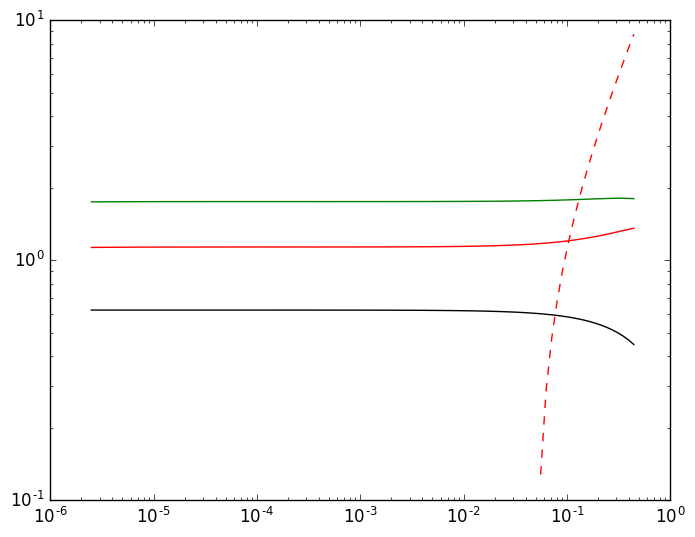

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3134a7ed0>

In [14]:
w_range = collect(0.01:0.01:100)
#yy = collect(0.01:0.01:1)
w_range = logspace(-6,4.5,100)
y_eff = sqrt(w_range)./N
s_eff = get_s_effective_two_level_interp(y_eff,alpha,beta,y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp)
s_birth_eff = get_s_birth_effective_two_level_interp(y_eff,alpha,y_susc_interp,y_sq_susc_interp)
s_death_eff = get_s_death_effective_two_level_interp(y_eff,beta,y_inf_interp)
loglog(y_eff,s_eff,"r")
loglog(y_eff,s_birth_eff,"g")
loglog(y_eff,s_death_eff,"k")
loglog(y_eff,s(y_eff,alpha,beta),"--r")
#xlim(0,0.01)
#plot(yy,y_sq_inf_interp(yy))
#y_inf_interp[sqrt(w_range)./N]

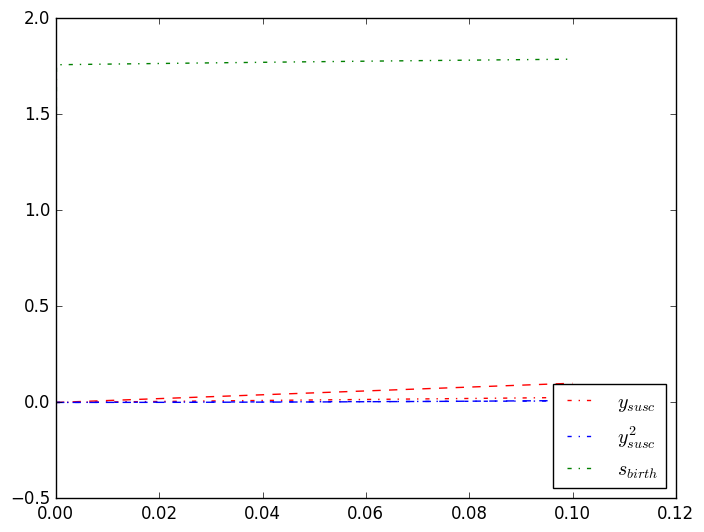

PyObject <matplotlib.legend.Legend object at 0x3142aea90>

In [15]:
using Dierckx
yy = 0:0.0001:0.1

# plot(yy,evaluate(y_inf_interp,yy),"r",label=L"y_{inf}")
# plot(yy,yy,"--r")

# plot(yy,evaluate(y_sq_inf_interp,yy),"b",label=L"y_{inf}^{2}")
# plot(yy,yy.^2,"--b")

plot(yy,evaluate(y_susc_interp,yy),"-.r",label=L"y_{susc}")
plot(yy,yy,"--r")

plot(yy,evaluate(y_sq_susc_interp,yy),"-.b",label=L"y_{susc}^2")
plot(yy,yy.^2,"--b")

 plot(yy,
 get_s_birth_effective_two_level_interp(collect(yy),alpha,y_susc_interp,y_sq_susc_interp),
 "-.g",label=L"s_{birth}")

#plot(yy,(1 - yy)./yy,"-k")
legend(loc="lower right")

#xlim([0,1])
#ylim([0,1])

In [ ]:
tolerance = 0.005
y_desired = 0.12



accum = get_mean_distribution_from_states(two_level_states,y_desired,tolerance)
accum_stationary = get_stationary_distribution(t.N,t.m,t.l,t.r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))



In [ ]:
accum_stationary = get_stationary_distribution(t.N,t.m,t.l,t.r,y_desired,((x,y) -> death_fn(x,y,beta)),((x,y) -> birth_fn(x,y,alpha)))


In [ ]:
#ion()
figure()

subplot(211)
title(latexstring("\$ \\bar{y} = $(y_desired)\$"))

semilogy(accum,label="graph simulation")
semilogy(accum_stationary,label="MCMC stationary distribution")
#xlabel("# of infecteds in subgraph")
ylabel("# of subgraphs")
grid()
legend()

subplot(212)
plot(accum,label="graph simulation")
plot(accum_stationary,label="MCMC stationary distribution")
xlabel("# of infecteds in subgraph")
ylabel("# of subgraphs")
grid()
legend()
savefig("../figures/mcmc_stationary_to_graph_comparison_y_$(y_desired).png")

In [ ]:
plot_schematics(N,alpha,beta,k,true)

In [ ]:
N = 1000
n_n = 400
c_r = 0.4
alpha,beta = get_alpha_beta(N,c_r,n_n)
plot_schematics(N,alpha,beta,k,true)
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);
IM.P_fix(im,N,1/N)

In [28]:
im = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,t.r + t.l) , x -> 1 + beta);
IM.P_fix(im,N,1/N)
# xx = 0:0.01:1
# plot(xx,get_s_eff(xx,alpha,beta,N-1))

0.02272815639230584

# why are there zero fixed for the graph case?

In [10]:
#using Grid
interpolation_function_path = "../data/interpolations.jld"
#y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)
#save(interpolation_function_path,"y_inf_interp",y_inf_interp,"y_sq_inf_interp",y_sq_inf_interp,"y_susc_interp",y_susc_interp,"y_sq_susc_interp",y_sq_susc_interp)
interpolation_functions = load(interpolation_function_path)
y_inf_interp = interpolation_functions["y_inf_interp"]
y_sq_inf_interp = interpolation_functions["y_sq_inf_interp"]
y_susc_interp = interpolation_functions["y_susc_interp"]
y_sq_susc_interp = interpolation_functions["y_sq_susc_interp"]



Spline1D(knots=[0.0024655,0.017541 … 0.977498,0.992513] (99 elements), k=2, extrapolation="extrapolate", residual=0.0)

In [195]:
# k = 4
# #y_n = 0.1
# c_r = 0.18
# N = 400#100000#400
# n_n = 10#10#y_n*N
# beta = 4.0/(c_r*n_n)
# alpha = (N*beta)/n_n
y_inf_interp,y_sq_inf_interp,y_susc_interp,y_sq_susc_interp = get_interpolations(t,alpha,beta)
println("N: $(N), n_n: $(n_n), l: $(t.l), t.r: $(t.r), ")
dt = get_dt_two_level(alpha,beta)
run_epidemic_fn = () -> run_epidemic_well_mixed_two_level(dt,N,y_susc_interp,y_sq_susc_interp,y_inf_interp,y_sq_inf_interp,alpha,beta,1.0)


N: 1000, n_n: 150, l: 10, t.r: 2, 


(anonymous function)

In [196]:
@time runs_two_level = run_epidemics(10000,run_epidemic_fn);

xvals_two_level_wm,pvals_two_level_wm = get_p_reach(runs_two_level)
xvals_two_level_wm /= N;

LoadError: LoadError: InterruptException:
while loading In[196], in expression starting on line 155

In [19]:
im_effective = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,t.l + t.r) , x -> 1 + beta);
runs_well_mixed = run_epidemics(10000, () -> run_epidemic_well_mixed(N,im_effective,1.0));

im_effective4 = InfectionModel(x -> 1 + beta + get_s_eff(x,alpha,beta,k) , x -> 1 + beta);
runs_well_mixed4 = run_epidemics(10000, () -> run_epidemic_well_mixed(N,im_effective4,1.0));



LoadError: LoadError: UndefVarError: alpha not defined
while loading In[19], in expression starting on line 1

([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0  …  77.0,79.0,80.0,81.0,84.0,92.0,99.0,400.0,401.0,402.0],[1.0,0.49096,0.31963,0.23334,0.18295,0.15012,0.12686,0.10843,0.09505,0.08494  …  0.01817,0.01816,0.01815,0.01814,0.01813,0.01812,0.01811,0.0181,0.001,3.0e-5])

In [47]:
pp = P_reach(s,splus,N,1/N,xx);

0.6476
0.

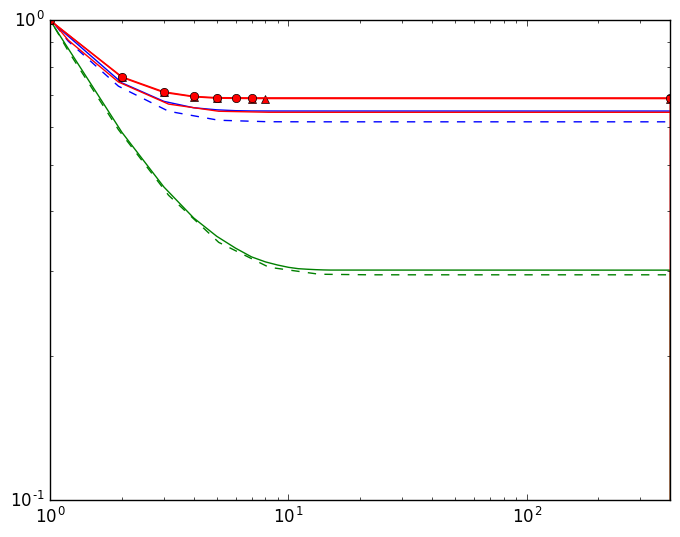

3019


(0.1,1.0)

In [43]:
sizes_two_level = get_sizes(runs_two_level)
num_fixed_two_level = get_num_fixed(runs_two_level)
xvals_two_level,pvals_two_level = get_p_reach(runs_two_level)
figure(3)
loglog(xvals_two_level,pvals_two_level,"b")
println(num_fixed_two_level/length(runs_two_level))

sizes_well_mixed = get_sizes(runs_well_mixed)
num_fixed_well_mixed = get_num_fixed(runs_well_mixed)
xvals_well_mixed,pvals_well_mixed = get_p_reach(runs_well_mixed)
xvals_well_mixed4,pvals_well_mixed4 = get_p_reach(runs_well_mixed4)
figure(3)
loglog(xvals_well_mixed,pvals_well_mixed,"g")
loglog(xvals_well_mixed4,pvals_well_mixed4,"-^r")
println(num_fixed_well_mixed/length(runs_well_mixed))


loglog(N*xx,pp,"--b")
loglog(N*xx,P_reach(im_effective,N,1/N,xx),"--g")
loglog(N*xx,P_reach(im_effective4,N,1/N,xx),"r")


#loglog(N*xvals_mixed_g,pvals_mixed_g,"-k")
loglog(N*xvals_regular4_g,pvals_regular4_g,"-or")
#loglog(N*xvals_two_level_g,pvals_two_level_g,"-k")
xlim([1,N])
ylim([0.1,1])

## Ideas for future work:

    ### - use clustering and second order properties ($y$, $q_{0,0}$, $q_{1,0}$
    ### - discretize a vector ($a_j$ is the number of subgraphs with a fraction $j/jmax$ of infecteds). Calculate the average incoming edges using variations in $k$.

In [ ]:
## Lior Pachter